In [1]:
# ==========================================================
# 04_GIN_embeddings.ipynb
# Pré-treinamento contrastivo com GIN (GCPAL-like)
# ==========================================================

# 0) Project setup (path fix for notebooks)
import sys
from pathlib import Path

# Detect project root (works in notebooks and scripts)
if "__file__" in globals():
    ROOT = Path(__file__).resolve().parents[1]
else:
    ROOT = Path.cwd().parents[0]  # assumes this notebook lives in /notebooks

# Add project root to sys.path so `src` can be imported (if needed)
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print(f"📁 Project root detected as: {ROOT.resolve()}")


📁 Project root detected as: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC


In [2]:
# ==========================================================
# Imports + config + device
# ==========================================================
import pandas as pd
from src.utils import ConfigLoader, EnvironmentSetup
from src.models.gcpal import (
    PretrainGraphBuilder,
    build_knn_edge_index,
    GINEncoder,
    ProjectionHead,
    build_positive_lists,
    GINPretrainer,
)

# config & device
cfg = ConfigLoader.load("base.yaml")
env = EnvironmentSetup(seed=cfg.get("general", {}).get("seed", 42))
device = env.device
print("device:", device)

data_proc = (ROOT / cfg["paths"]["data_processed"]).resolve()
print("data_processed:", data_proc)


✅ Active device: cpu
GPU detected: None
Torch version: 2.8.0
device: cpu
data_processed: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/processed


In [3]:
# ==========================================================
# Carrega CSVs processados do 01/03
# ==========================================================
nodes_with_class_path = data_proc / "elliptic_nodes_with_class.csv"
edges_path            = data_proc / "elliptic_edges.csv"

df_nodes_with_class = pd.read_csv(nodes_with_class_path)
df_edges            = pd.read_csv(edges_path)

print("nodes_with_class:", df_nodes_with_class.shape)
print("edges:", df_edges.shape)


nodes_with_class: (203769, 168)
edges: (234355, 2)


In [4]:
# ==========================================================
# Grafo ÚNICO de pré-treino (time_step <= 34) com PretrainGraphBuilder
# ==========================================================
feature_cols = [c for c in df_nodes_with_class.columns if c.startswith("feature_")]

pt_builder = PretrainGraphBuilder(
    df_nodes_with_class=df_nodes_with_class,
    df_edges=df_edges,
    feature_cols=feature_cols,
    max_train_step=cfg.get("pretrain", {}).get("max_train_step", 34),
    device=device,
)
data_train_global = pt_builder.build()


Data(x=[136265, 165], edge_index=[2, 313686], y=[136265], mask_labeled=[136265])
Total de nós (≤34): 136265
Total de arestas (bidirecionais): 313686
Nós rotulados: 29894
Proporção de ilícitos nos rotulados: 0.11580919474363327


In [5]:
# ==========================================================
# KNN view (k=15 por padrão, pode vir do YAML)
# ==========================================================
k = cfg.get("pretrain", {}).get("k", 15)
knn_bs = cfg.get("pretrain", {}).get("knn_batch_size", 4096)

edge_index_knn = build_knn_edge_index(
    x=data_train_global.x.to(device),
    k=k,
    batch_size=knn_bs,
    device=device,
)

print("edge_index_knn:", tuple(edge_index_knn.size()))


edge_index_knn: (2, 4087992)


In [6]:
# ==========================================================
# Modelo: GINEncoder + ProjectionHead
# ==========================================================
in_dim      = data_train_global.x.size(1)
hidden_dim  = cfg.get("model", {}).get("gin", {}).get("hidden_dim", 128)
layers      = cfg.get("model", {}).get("gin", {}).get("layers", 2)
proj_dim    = cfg.get("model", {}).get("gin", {}).get("proj_dim", 128)

encoder  = GINEncoder(in_channels=in_dim, hidden_channels=hidden_dim, num_layers=layers).to(device)
proj_head = ProjectionHead(in_dim=hidden_dim, proj_dim=proj_dim).to(device)

print("encoder/proj prontos:", in_dim, hidden_dim, layers, proj_dim)


encoder/proj prontos: 165 128 2 128


In [7]:
# ==========================================================
# Listas de positivos (A estrutural e A_KNN)
# ==========================================================
pos_lists_struct = build_positive_lists(
    edge_index=data_train_global.edge_index.to("cpu"),
    num_nodes=data_train_global.num_nodes,
    add_self=True,
)
pos_lists_knn = build_positive_lists(
    edge_index=edge_index_knn.to("cpu"),
    num_nodes=data_train_global.num_nodes,
    add_self=True,
)

len(pos_lists_struct), len(pos_lists_knn)


(136265, 136265)

In [8]:
# # ==========================================================
# # Treino contrastivo com GINPretrainer (rodar no Colab)
# # ==========================================================
# pre = cfg.get("pretrain", {})

# trainer = GINPretrainer(
#     device=device,
#     lambda_mix=pre.get("lambda_mix", 0.5),
#     tau=pre.get("tau", 0.5),
#     lr=pre.get("lr", 1e-3),
#     max_epochs=pre.get("epochs", 20),
#     anchor_bs=pre.get("anchor_bs", 2048),
#     target_bs=pre.get("target_bs", 32768),
#     patience=pre.get("patience", 999),
#     drop_p_edge=pre.get("drop_p_edge", 0.3),
#     drop_p_feat=pre.get("drop_p_feat", 0.3),
# )

# metrics = trainer.fit(
#     data_train_global=data_train_global,
#     edge_index_knn=edge_index_knn,
#     encoder=encoder,
#     proj_head=proj_head,
#     pos_lists_struct=pos_lists_struct,
#     pos_lists_knn=pos_lists_knn,
# )

# metrics


In [9]:
# # ==========================================================
# # Export GCPAL embeddings (raw + optional PCA) to CSVs - Rodar no Colab
# # ==========================================================
# from pathlib import Path
# import pandas as pd
# from src.models.gcpal import SafeSplitBuilder, EmbeddingExporter

# # 1) Ranges & paths
# s = cfg["splits"]
# data_proc = (ROOT / cfg["paths"]["data_processed"]).resolve()
# splits_dir = data_proc / "splits"
# emb_dir = data_proc / "embeddings"

# # 2) Load labeled tabular splits (saved in 03)
# df_train = pd.read_csv(splits_dir / "train_nodes.csv")
# df_test1 = pd.read_csv(splits_dir / "test1_nodes.csv")
# df_test2 = pd.read_csv(splits_dir / "test2_nodes.csv")

# # 3) Build safe PyG splits (local contiguous indexing)
# feature_cols = [c for c in df_nodes_with_class.columns if c.startswith("feature_")]
# split_builder = SafeSplitBuilder(df_nodes_with_class, df_edges, feature_cols)
# data_train, data_test1_split, data_test2_split = split_builder.build_train_test_splits(
#     train_lo=1, train_hi=s["train_upper"],
#     test1_lo=s["test1_lower"], test1_hi=s["test1_upper"],
#     test2_lo=s["test2_lower"], test2_hi=s["test2_upper"],
# )

# # 4) Extract embeddings with safe GPU→CPU fallback
# E_train  = EmbeddingExporter.extract_H_safe(encoder, data_train,       device)
# E_test1  = EmbeddingExporter.extract_H_safe(encoder, data_test1_split, device)
# E_test2  = EmbeddingExporter.extract_H_safe(encoder, data_test2_split, device)

# # 5) DataFrames (emb_gcpal_*, + txId)
# emb_train_df, emb_test1_df, emb_test2_df = EmbeddingExporter.to_dataframes(
#     E_train, E_test1, E_test2,
#     data_train, data_test1_split, data_test2_split,
# )

# # 6) Merge with labeled splits
# df_train_emb, df_test1_emb, df_test2_emb, df_test_emb = EmbeddingExporter.merge_with_splits(
#     df_train, df_test1, df_test2,
#     emb_train_df, emb_test1_df, emb_test2_df,
# )

# # 7) Optional PCA on embeddings (fit on train, transform test)
# n_comp = cfg.get("pretrain", {}).get("pca_components", 30)
# E_train_pca, pca = EmbeddingExporter.pca_fit_transform(E_train, n_components=n_comp, random_state=cfg.get("general", {}).get("seed", 42))
# E_test1_pca = EmbeddingExporter.pca_transform(pca, E_test1)
# E_test2_pca = EmbeddingExporter.pca_transform(pca, E_test2)

# df_train_pca, df_test1_pca, df_test2_pca = EmbeddingExporter.pca_dataframes(
#     E_train_pca, E_test1_pca, E_test2_pca,
#     data_train, data_test1_split, data_test2_split,
# )

# # 8) Save CSVs (filenames already include *_gcpal)
# EmbeddingExporter.save_csvs(
#     out_dir=emb_dir,
#     df_train_emb=df_train_emb,
#     df_test1_emb=df_test1_emb,
#     df_test2_emb=df_test2_emb,
#     df_train_pca=df_train_pca,
#     df_test1_pca=df_test1_pca,
#     df_test2_pca=df_test2_pca,
# )

# print("✅ Embeddings salvos em:", emb_dir.resolve())
# print("   -", "train_embeddings_gcpal.csv")
# print("   -", "test1_embeddings_gcpal.csv")
# print("   -", "test2_embeddings_gcpal.csv")
# print("   -", "train_embeddings_pca_gcpal.csv")
# print("   -", "test1_embeddings_pca_gcpal.csv")
# print("   -", "test2_embeddings_pca_gcpal.csv")


In [10]:
# Salvando os embeddings no Google Drive (apenas no Colab)

# from pathlib import Path
# print((emb_dir).resolve())         # mostra o caminho completo
# !ls -lh "{emb_dir}"

# # mover para .../MyDrive/TCC/data/processed/embeddings
# !mkdir -p /content/drive/MyDrive/TCC/data/processed/embeddings
# !mv /content/drive/MyDrive/data/processed/embeddings/* /content/drive/MyDrive/TCC/data/processed/embeddings/
# !rmdir /content/drive/MyDrive/data/processed/embeddings

# from google.colab import files
# !cd /content/drive/MyDrive/TCC/data/processed/embeddings && zip -r embeddings_gcpal.zip .
# files.download('/content/drive/MyDrive/TCC/data/processed/embeddings/embeddings_gcpal.zip')


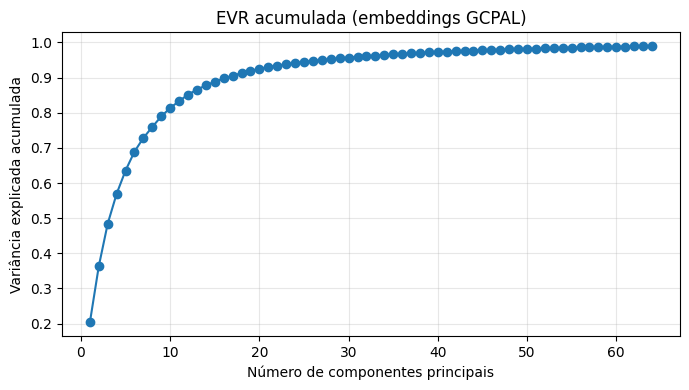

In [12]:
# ==========================================================
# EVR (variância explicada) vs nº de componentes (1..64) — apenas plot
# ==========================================================
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Caminho para o CSV de treino (ajuste ROOT/cfg se necessário)
emb_dir = (ROOT / cfg["paths"]["data_processed"] / "embeddings").resolve()
csv_train = emb_dir / "train_embeddings_gcpal.csv"

# Carrega embeddings de treino
df = pd.read_csv(csv_train)
X = df[[c for c in df.columns if c.startswith("emb_gcpal_")]].values

# Padroniza e ajusta PCA até 64 PCs (ou até o nº de features)
X_std = StandardScaler().fit_transform(X)
n_comp = min(64, X_std.shape[1])
pca = PCA(n_components=n_comp, random_state=cfg.get("general", {}).get("seed", 42))
pca.fit(X_std)

evr_cum = np.cumsum(pca.explained_variance_ratio_)

# Plot único (sem salvar)
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(range(1, n_comp + 1), evr_cum, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Variância explicada acumulada")
ax.set_title("EVR acumulada (embeddings GCPAL)")
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()
